In [32]:
import pymc
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

In [33]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 2.1

In [34]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

## 2.2

The probability of observing six W's in 9 tosses:

In [35]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000003

## 2.3 and 2.5

**The code in PyMC had this as 5 but I think this can be really any number since we're just using a 
uniform prior and aren't make any assumptions about the plausible values about pi**

* It justs has to be the same length as the grid we define.

In [46]:
def uniform_prior(grid_points):
    return np.repeat(1, grid_points)

def truncated_prior(grid_points, trunc_point=0.5):
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)

def double_exp_prior(grid_points):
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

This makes the code clearer to me - we're assigning the same probability to each possible value that $\pi$ can take, which is defined by the size of our grid.

In [37]:
def test_uniform(grid_points):
    return np.repeat(1, grid_points) / grid_points

In [38]:
test_uniform(50)

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

* We use `pmf()` since a Binomial is a discrete distribution.

In [39]:
def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    p_grid = np.linspace(0, 1, grid_points)
    
    prior = prior_func(grid_points)
    likelihood = stats.binom.pmf(success, tosses, p_grid)
    
    unstd_posterior = likelihood * prior
    
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

In [40]:
grid_points = 10

prior = uniform_prior(grid_points)
grid = np.linspace(0, 1, grid_points)
likelihood = stats.binom.pmf(6, 9, grid)

unstd_posterior = likelihood * prior
(unstd_posterior / unstd_posterior.sum()).sum()


1.0

## 2.3

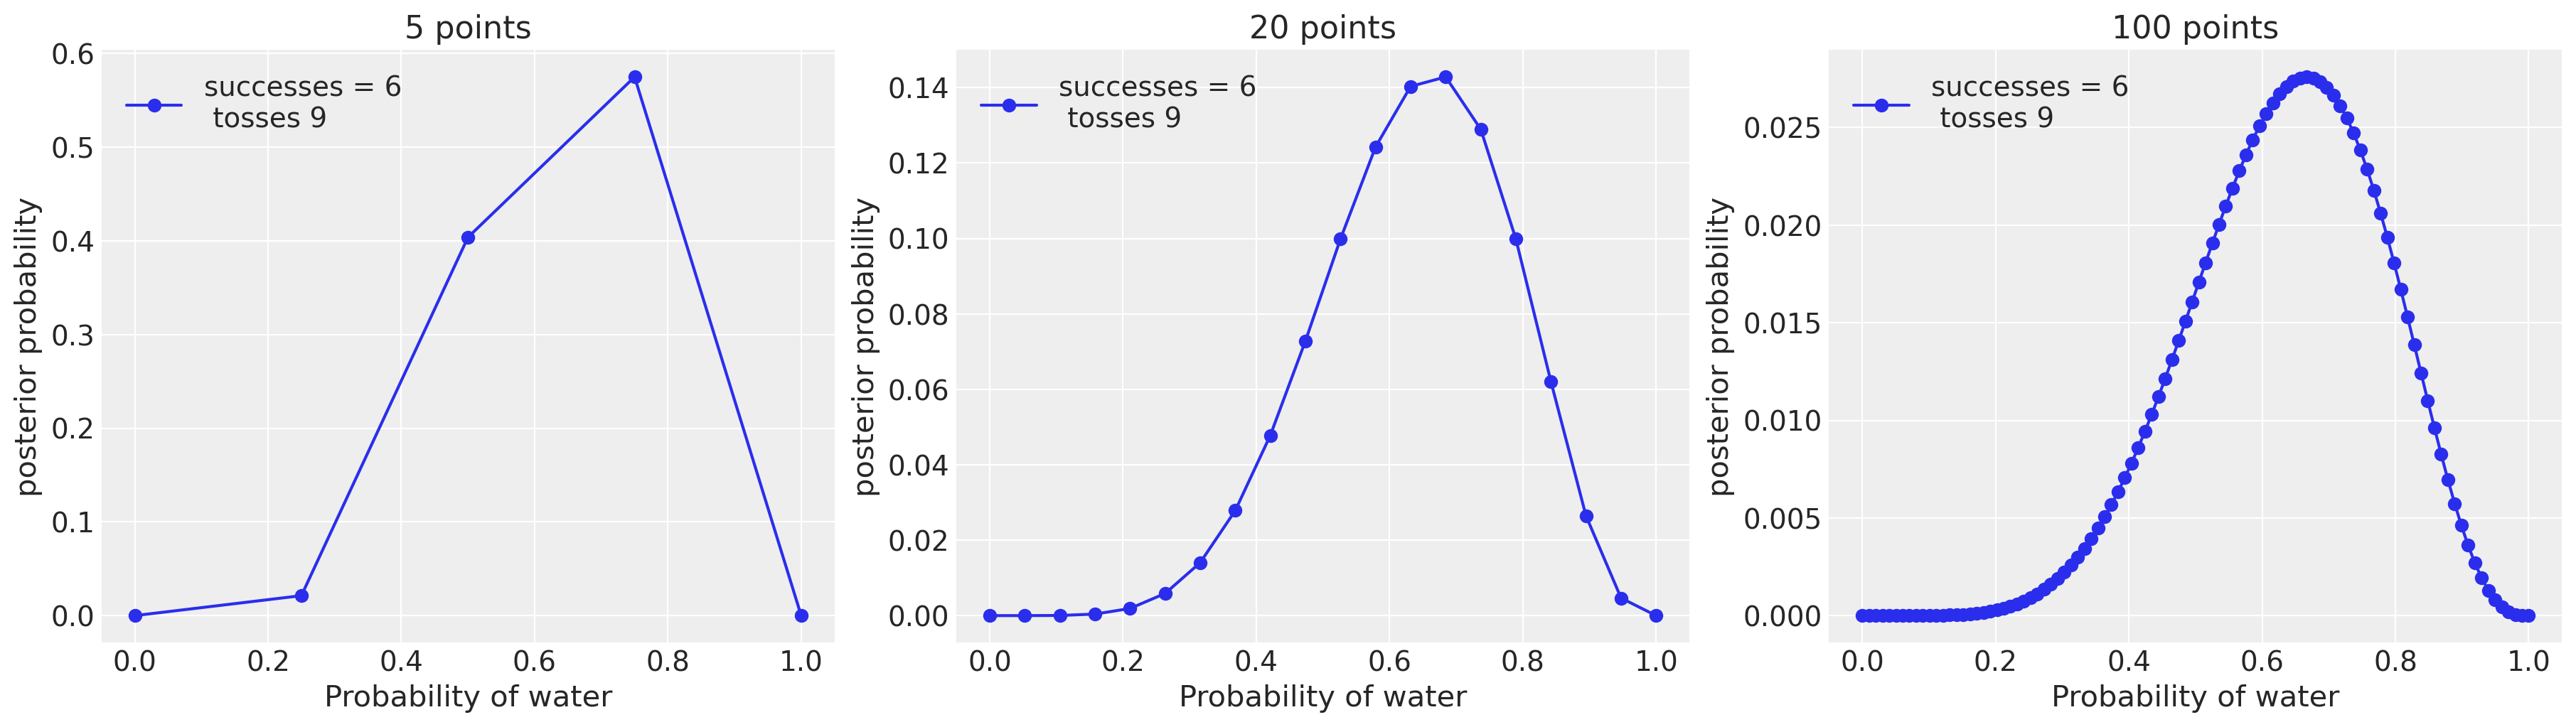

In [41]:
w, n = 6, 9

points = (5, 20, 100)

_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(test_uniform, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\n tosses {n}")
    ax[idx].set_xlabel("Probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

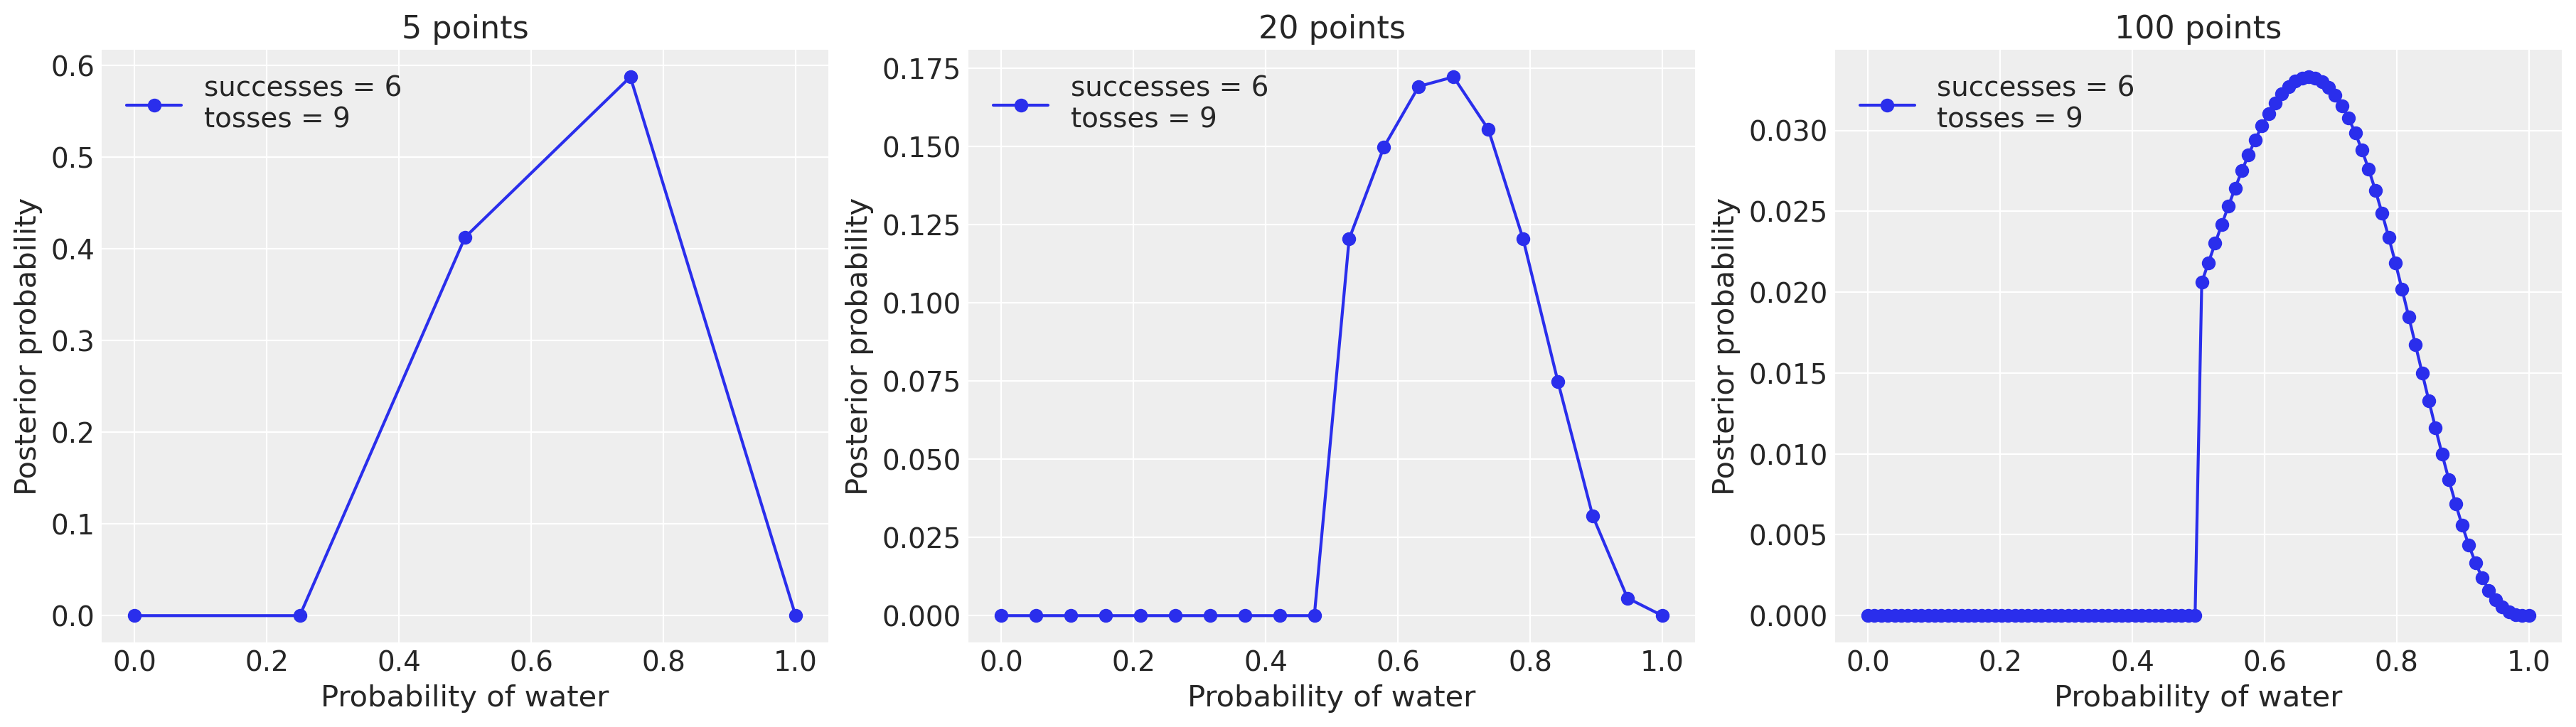

In [44]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(truncated_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("Probability of water")
    ax[idx].set_ylabel("Posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

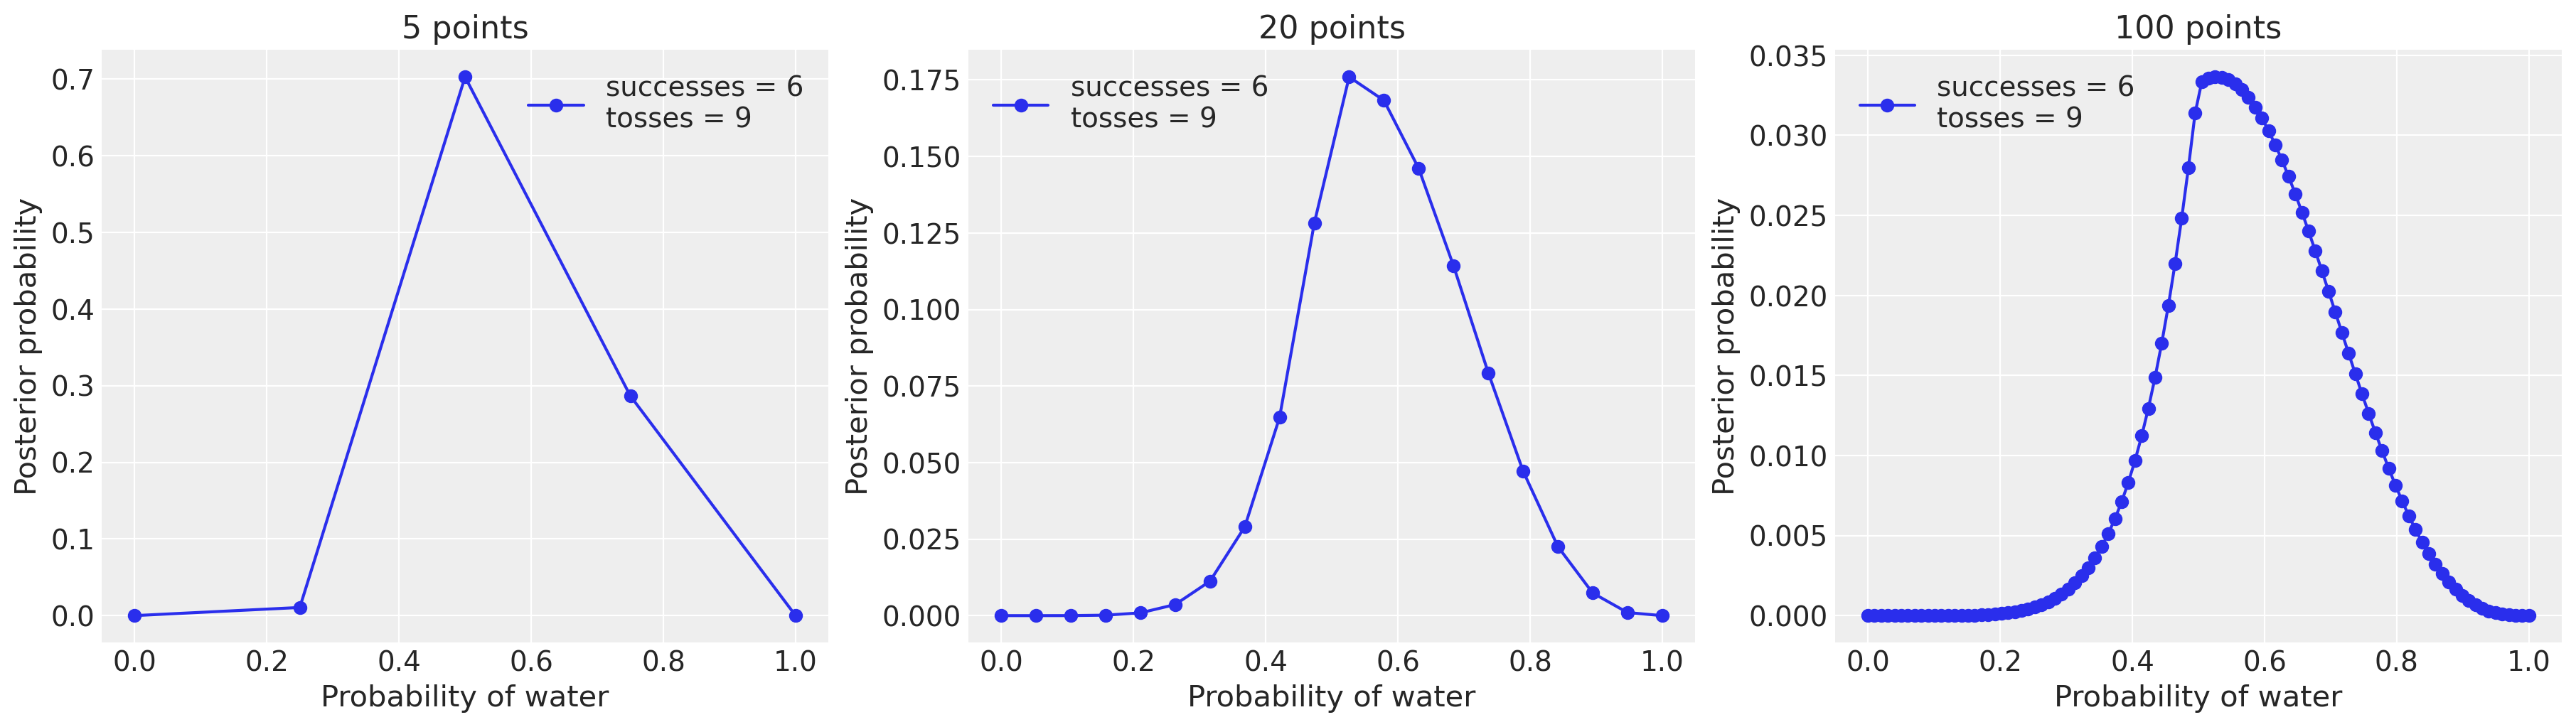

In [47]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(double_exp_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("Probability of water")
    ax[idx].set_ylabel("Posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

## 2.6

In [48]:
np.repeat((0, 1), (3, 6))

array([0, 0, 0, 1, 1, 1, 1, 1, 1])